In [12]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


DATE = '2020-09-26_EnvAlt'
EXP = 'exp14_lr0.001_lba0.5_kpa1_sup0.75'
LOAD_DIR = Path('../saved_data') / DATE / EXP

# load general data
config = torch.load(LOAD_DIR / 'config')
total_rewards = torch.load(LOAD_DIR / 'tot_r')
times = torch.load(LOAD_DIR / 'running_times')

# load state data
versions = ['optim0', 'optim100']
states = dict()
plots = []
fig_count = 0
for version in versions:
    states.update({version: torch.load(LOAD_DIR / ('batch_states_' + version))})

In [66]:
config

{'agents': ['FSC', 'Shell', 'Gov'],
 'active_agents': ['FSC', 'Shell'],
 'init_support': [inf, 0.7, 0.7],
 'init_resource': {'Shell': [0.03, 0.94, 0.03], 'Gov': [0.5, 0.5]},
 'delta_resource': 0.03,
 'delta_research': 0.17,
 'base_impacts': {'Shell': [0.38, 0.11], 'Gov': [0.03, 0.33]},
 'beta': 0.05,
 'lambda': 0.5,
 'max subsidy': 0.5,
 'reward_function': 'fsc_V2.3_eps0.15_0.17_shell_V2.2div_0.0004',
 'length_ep': 78,
 'n_ep': 1000,
 'lr': 0.001,
 'batch_size': 10,
 'gamma': 0.99,
 'save_interval': 5}

<h2><center>plots for total reward </center></h2>

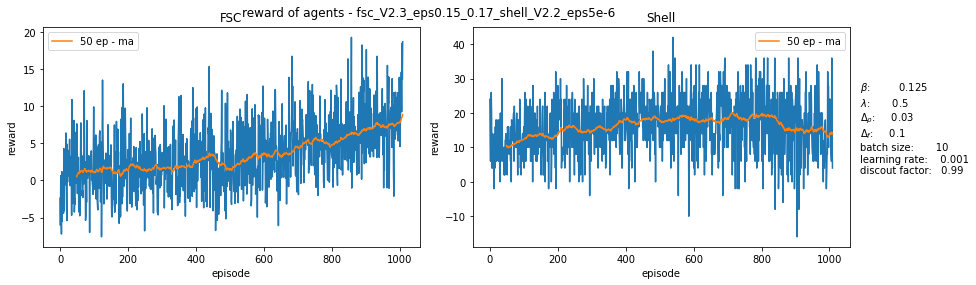

In [13]:
#plot total rewards of active agents and the rolling mean
window_width = 50

fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
ax = [fig.add_subplot(121), fig.add_subplot(122)]
fig_count += 1

for i, agt in enumerate(config['active_agents']):
    ma = pd.Series(total_rewards[agt]).rolling(window_width).mean()
    ax[i].plot(total_rewards[agt])
    ax[i].plot(ma, label='{} ep - ma'.format(window_width))
    ax[i].set_title(agt)
    ax[i].set_xlabel('episode')
    ax[i].set_ylabel('reward')
    ax[i].legend()
fig.suptitle('reward of agents - ' + config['reward_function'])
fig.tight_layout()
fig.text(1, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                 r'$\lambda$:' + '\t {}'.format(config['lambda']) + '\n' +
                 r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                 r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                  'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                  'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                  'discout factor:' + '   {}'.format(config['gamma']));

<h2><center>network analysis</center></h2>

In [14]:
# determine dead neurons by calculation of difference of weights
agents = [torch.load(LOAD_DIR / 'agents_init'), torch.load(LOAD_DIR / 'agents_optim1_ep10')]
weights_diff = []
weights_diff.append(agents[0]['FSC'].get_networks()['All'][0].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['All'][0].weight.detach().numpy())
weights_diff.append(agents[0]['FSC'].get_networks()['All'][2].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['All'][2].weight.detach().numpy())
for i in weights_diff:
    print(np.where(np.all(np.isclose(i, 0), axis=1)))
    print(i)

(array([], dtype=int64),)
[[-0.00099992 -0.00099996 -0.0009996  -0.00099972]
 [-0.00099959 -0.0009999  -0.00099903 -0.00099948]
 [ 0.00099973  0.00099996  0.00099948  0.00099972]
 [ 0.00099973  0.00099993 -0.00099982 -0.00099993]
 [-0.00099936  0.00099991  0.00099939  0.00099975]
 [ 0.00099999  0.001       0.00099997  0.00099999]
 [-0.00099999 -0.00099999 -0.00099994 -0.00099996]
 [ 0.00099996  0.00099999  0.00099995  0.00099999]
 [-0.00099999 -0.001      -0.00099996 -0.00099999]
 [-0.00099996 -0.00099999  0.00099993 -0.00099994]
 [-0.00099984 -0.00099982 -0.00099802 -0.00099337]
 [ 0.0009999   0.00099999  0.00099978  0.00099987]
 [-0.00099996 -0.00099999 -0.00099993 -0.00099996]
 [ 0.00099999  0.00099999  0.00099996  0.00099997]
 [ 0.00099999  0.00099999  0.00099997  0.00099999]
 [ 0.00099972  0.00099988  0.00099915  0.00099955]]
(array([], dtype=int64),)
[[ 0.001       0.001       0.001      -0.001       0.001      -0.001
  -0.001       0.00099999 -0.001       0.001       0.001      

In [16]:
agents[0]['FSC']

<h2><center>plots for support</center></h2>

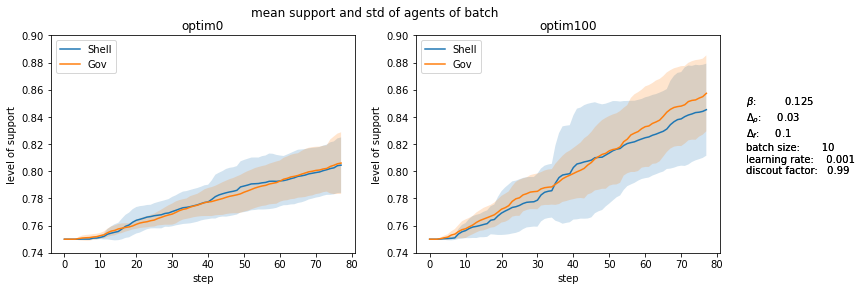

In [9]:
fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
fig_count += 1
ax = [fig.add_subplot(121), fig.add_subplot(122)]

# loop over all versions
for i, version in enumerate(versions):

    # loop over each agent
    for key in ['Shell', 'Gov']:
        # calculate mean and std for support
        mean = states[version][key].mean(axis=0)[:, 0]
        std = states[version][key].std(axis=0)[:, 0]
        x = range(0, states[version][key].shape[1])
        # plot mean
        ax[i].plot(mean, label=key)
        # plot std as an area
        ax[i].fill_between(x, mean+std, mean-std, alpha=0.2)

    # set some plot properties
    fig.suptitle('mean support and std of agents of batch')
    fig.text(0.93, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                        r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                        r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                         'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                         'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                         'discout factor:' + '   {}'.format(config['gamma']));
    ax[i].set_title(version)
    ax[i].set_xlabel('step')
    ax[i].set_ylabel('level of support')
    ax[i].legend(loc='upper left')
# ax[0].set_yticklabels(ax[1].get_yticklabels())
ax[0].set_yticks(ax[1].get_yticks());
ax[1].set_yticks(ax[1].get_yticks());

<h2><center>plots for agent strategy</center></h2>

<h3>Shell: resource allocation</h3>

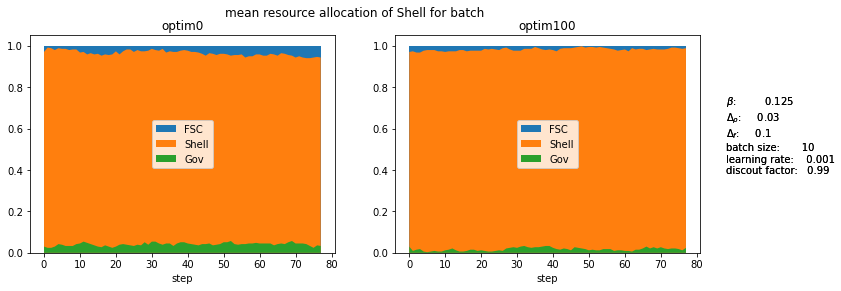

In [14]:
fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
# create new axes
ax = [fig.add_subplot(121), fig.add_subplot(122)]
fig_count += 1

for i, version in enumerate(versions):
    key = 'Shell'
    # calculate mean of resource assignment to the different partner agents
    x = range(0, states[version][key].shape[1])
    fsc = states[version][key].mean(axis=0)[:, 1] #[0,:,1] #
    shell = states[version][key].mean(axis=0)[:, 2] #[0,:,2]#
    gov = states[version][key].mean(axis=0)[:, 3] #[0,:,3]#

    # create stacked plots
    ax[i].stackplot(x, gov + shell + fsc)
    ax[i].stackplot(x, gov + shell)
    ax[i].stackplot(x, gov)
    ax[i].set_title(version)
    ax[i].set_xlabel('step')
    ax[i].legend(['FSC', 'Shell', 'Gov'], loc='center')
    fig.suptitle('batch mean resource allocation of Shell')
    fig.text(0.93, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                    r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                    r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                     'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                     'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                     'discout factor:' + '   {}'.format(config['gamma']));

<h3>FSC: states</h3>

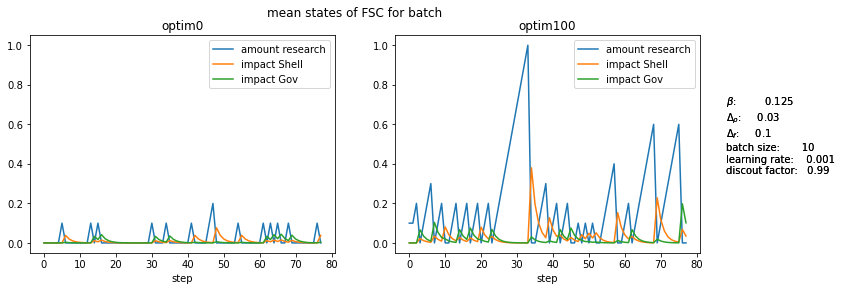

In [11]:
fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
# create new axes
last = fig.add_subplot(122)
ax = [fig.add_subplot(121, sharey=last), last]
fig_count += 1

for i, version in enumerate(versions):
    key = 'FSC'
    # calculate mean of resource assignment to the different partner agents
    x = range(0, states[version][key].shape[1])
    research = states[version][key][0,:,1] #.mean(axis=0)[:, 1] #
    impact_shell = states[version][key][0,:,2]#.mean(axis=0)[:, 2] # 
    impact_gov = states[version][key][0,:,3]#mean(axis=0)[:, 3] #

    # create stacked plots
    ax[i].plot(x, research, label='amount research')
    ax[i].plot(x, impact_shell, label='impact Shell')
    ax[i].plot(x, impact_gov, label='impact Gov')
    ax[i].set_title(version)
    ax[i].set_xlabel('step')
    ax[i].legend()
    fig.suptitle('mean states of FSC for batch')
    fig.text(0.93, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                    r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                    r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                     'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                     'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                     'discout factor:' + '   {}'.format(config['gamma']));

<h2><center>plots for support calculation</center></h2>

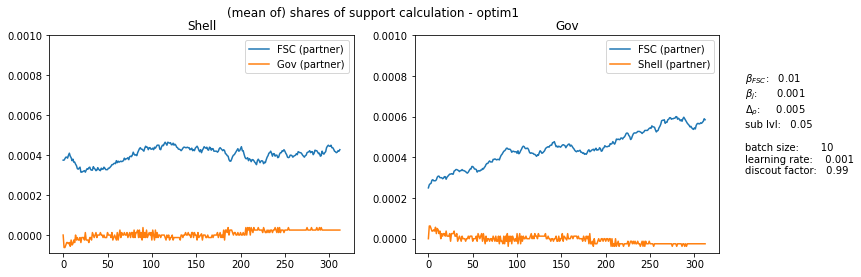

In [4]:
# %matplotlib notebook
# %matplotlib inline
support_calc = dict()
par_agt = {'Shell': ['FSC', 'Gov'], 'Gov': ['FSC', 'Shell']}
for version in versions:
    # load data
    support_calc.update({version: torch.load(LOAD_DIR / ('support_calc_' + version))})
    # create figure and axis
    fig = plt.figure(fig_count, figsize=(12, 4))    
    plots.append(fig)  
    fig_count += 1
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    
    for i, key in enumerate(support_calc[version].keys()):
        x = range(0, support_calc[version][key].shape[1])
        mean = support_calc[version][key].mean(axis=0)[:, :]               
#         ax[i].plot(mean[:,0], label='support before' ) # oder raus
        ax[i].plot(mean[:,1], label= par_agt[key][0] + ' (partner)')
        ax[i].plot(mean[:,2], label= par_agt[key][1] + ' (partner)')
        ax[i].legend()
        ax[i].set_title(key)
        ax[i].set_ylim(ymax=0.001)
    fig.suptitle('(mean of) shares of support calculation - ' + version)
    fig.text(0.93, 0.4, r'$\beta_{FSC}$:' + '\t {}'.format(config['support_factor']) + '\n' +
                        r'$\beta_{j}$:' + ' \t  {}'.format(config['support_factor'] * config['ratio of support factor']) + '\n' +
                        r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                         'sub lvl:' + '   {}'.format(config['sub_lvl'])  + '\n\n' +
                         'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                         'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                         'discout factor:' + '   {}'.format(config['gamma']))                
    

In [ ]:
# support von Gov ist genau das gespiegelte von Shell
support_calc[version]['Gov'].mean(axis=0)[:,:][:,2] + support_calc[version]['Shell'].mean(axis=0)[:,:][:,2]

<h2><center>plots for shell reward calculation</center></h2>

In [ ]:
reward_shell = dict()
for version in versions:
    # load data
    reward_shell.update({version: torch.load(LOAD_DIR / ('reward_shell_calc_' + version))})
    fig = plt.figure(fig_count)
    fig_count += 1
    ax = fig.add_subplot(111)
    
    mean = reward_shell[version].mean(axis=0)[:, :]
    x = range(0, reward_shell[version].shape[1])
    
    # create stacked plots
    ax.stackplot(x, mean[:, 3] + mean[:, 2] + mean[:, 1])
    ax.stackplot(x, mean[:, 3] + mean[:, 2])
    ax.stackplot(x, mean[:, 3])
    
    # axis properties
    ax.legend(['own return', 'external spending', 'internal spending'])
    ax.set_title('mean of shares of discounted reward for Shell - ' + version)
    fig.text(0.93, 0.4, r'$\beta_{FSC}$:' + '\t {}'.format(config['support_factor']) + '\n' +
                    r'$\beta_{j}$:' + ' \t  {}'.format(config['support_factor'] * config['ratio of support factor']) + '\n' +
                    r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                     'sub lvl:' + '   {}'.format(config['sub_lvl'])  + '\n\n' +
                     'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                     'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                     'discout factor:' + '   {}'.format(config['gamma']))

<h2><center>saving plots to pdf or svg</center></h2>

In [5]:
plots

[<Figure size 864x288 with 2 Axes>]

In [12]:
plots[0].savefig((LOAD_DIR / (DATE + '_' + EXP + '_' + '_rewards' + '.pdf')), bbox_inches="tight")

In [ ]:
for i, version in enumerate(versions):
    plots[1+i].savefig((LOAD_DIR / (DATE + '_' + EXP + '_'  + versions[i] + '_support' + '.pdf')), bbox_inches="tight") # svg auch möglich

In [ ]:
plots[1]

<h2><center>load classes to load agents with pickle/torch</center></h2>

In [11]:
import copy
import torch
import numpy as np
from torch import nn

np.random.seed(42)


class Agent(object):
    def __init__(self, act_space, n_state, device):
        self.__state = None
        self.__n_neurons = 16
        self.__action_space = act_space
        self._device = device

        # Define network
        self.__base_network = nn.Sequential(nn.Linear(n_state, self.__n_neurons),
                                            nn.ReLU(),
                                            nn.Linear(self.__n_neurons, len(act_space)),
                                            nn.Softmax(dim=-1))

    def get_actions(self, state) -> dict:
        raise NotImplementedError

    def get_base_net(self):
        return self.__base_network

    def get_action_space(self):
        return self.__action_space


class Shell(Agent):
    def __init__(self, action_space, n_state, act_partners, device):
        super().__init__(action_space, n_state, device)
        self.__networks = dict()

        # initialize all necessary networks by copying the base network and send it to device
        for agt in act_partners:
            self.__networks.update({agt: copy.copy(super().get_base_net()).to(device)})

    def get_actions(self, state) -> dict:
        nets = self.__networks
        actions = dict()

        # derive an action for each network (i.e., policy)
        for key in nets.keys():
            # detach() should not be a problem hear, as for optimization predict() is called again,
            # where no detach() is used
            action_probs = self.predict(state, key).cpu().detach().numpy()
            actions.update({key: np.random.choice(super().get_action_space(), p=action_probs)})
        return actions

    def predict(self, state, partner_agt):
        # get the action probabilities as a tensor
        action_probs = self.__networks[partner_agt](torch.FloatTensor(state).to(self._device))
        return action_probs

    def get_networks(self):
        return self.__networks


class FSC(Agent):
    def __init__(self, action_space, n_state, act_partners, device):
        super().__init__(action_space, n_state, device)
        self.__networks = dict()
        self.__action_space = action_space

        # initialize all necessary networks by copying the base network and send it to device
        for agt in act_partners:
            self.__networks.update({agt: copy.copy(super().get_base_net()).to(device)})

    def get_actions(self, state) -> dict:
        nets = self.__networks
        actions = dict()

        # derive an action for each network (i.e., policy)
        for key in nets.keys():
            action_probs = self.predict(state, key).cpu().detach().numpy()
            actions.update({key: np.random.choice(super().get_action_space(), p=action_probs)})
        return actions

    def predict(self, state, partner_agt):
        # get the action probabilities as a tensor
        action_probs = self.__networks[partner_agt](torch.FloatTensor(state).to(self._device))
        return action_probs

    def get_networks(self):
        return self.__networks


class Gov(Agent):
    def __init__(self, action_space, n_state, activ_con, device):
        # super().__init__(action_space, n_state)
        pass

    def get_actions(self, state) -> dict:
        # government is performing maintain as action. That equals an passiv agent.
        return {'Shell': 0, 'FSC': 0}

